# NLP Applications: Text Spam Classification using Word2Vec, SMOTE and Machine Learning Models

In [1]:
# baseline
import numpy as np

# preprocessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Word2Vec
import gensim
from gensim.models import Word2Vec

# undersampling and scaling/standardizing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# model building
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# final visualizations
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\steph\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steph\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 1: Data Loading

In [2]:
df_train = pd.read_csv('data/SMS_train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('data/SMS_test.csv', encoding = "ISO-8859-1")
df_full = pd.concat([df_train, df_test])

In [3]:
df_full.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [4]:
df_full['Label'].value_counts()

Non-Spam    884
Spam        198
Name: Label, dtype: int64

# Step 2: Preprocessing

Credit to Vijaya Rani for her original implementation of text preprocessing and Word2Vec functions: [tutorial article](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)

In [5]:
df_full = df_full[['Message_body', 'Label']].replace({'Non-Spam':0, 'Spam':1})
df_full.head()

,Message_body,Label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1


In [6]:
# converting to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# removing stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# lemmatization initialization
wl = WordNetLemmatizer()
 
# maps NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# lemmatizing and tokenizing function
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# apply functions to unclean message text
df_full['cleaned_message'] = df_full['Message_body'].apply(lambda x: finalpreprocess(x))
df_full.head()

,Message_body,Label,cleaned_message
0,Rofl. Its true to its name,0,rofl true name
1,The guy did some bitching but I acted like i'd...,0,guy bitch act like interested buying something...
2,"Pity, * was in mood for that. So...any other s...",0,pity mood suggestion
3,Will ü b going to esplanade fr home?,0,ü b go esplanade fr home
4,This is the 2nd time we have tried 2 contact u...,1,nd time try contact u u pound prize claim easy...


In [7]:
X = df_full['cleaned_message']
y = df_full['Label']

# Step 3: Word Vectorization using Word2Vec

Credit to Vijaya Rani for her original implementation of text preprocessing and Word2Vec functions: [tutorial article](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)

In [8]:
# tokenize X
X_token = [nltk.word_tokenize(i) for i in X]
X_token[0]

['rofl', 'true', 'name']

In [9]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df_full['clean_text_tok']=[nltk.word_tokenize(i) for i in df_full['cleaned_message']]
model = Word2Vec(df_full['clean_text_tok'],min_count=1)     
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)


In [10]:
X_vectors = modelw.transform(X_token)
X_vectors.shape

(1082, 100)

# Step 4: Data Balancing, Scaling, and Splitting

In [11]:
# oversampling process
def data_balancing(X, y, under_pct=0.1, over_pct=0.5):
    over = SMOTE(sampling_strategy=under_pct, random_state=1)
    under = RandomUnderSampler(sampling_strategy=over_pct)
    steps = [('o', over)]#, ('u', under)]
    pipeline = Pipeline(steps=steps)
    X_bal, y_bal = pipeline.fit_resample(X, y)
    
    print(f'Original Class Counts: \n{y.value_counts()}\n\nNew Class Counts (over {over_pct*100}%): \n{y_bal.value_counts()}')
    return X_bal, y_bal

# preprocessing function
def split_and_scale(X, y, test_size=0.20):
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # scale dataset
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [12]:
# get balanced data
X_balanced, y_balanced = data_balancing(X_vectors, df_full['Label'], under_pct=0.6, over_pct=0.6)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = split_and_scale(X_balanced, y_balanced, test_size=0.15)

# get unbalanced data
X_train, X_test, y_train, y_test = split_and_scale(X_vectors, df_full['Label'])

Original Class Counts: 
0    884
1    198
Name: Label, dtype: int64

New Class Counts (over 60.0%): 
0    884
1    530
Name: Label, dtype: int64


# Step 4: Machine Learning Models

### Logistic Regression

In [13]:
# find optimal logistic regression parameters
i=0
for subset in [(X_train_bal, y_train_bal), (X_train, y_train)]:
    name='Balanced Dataset'
    if i==1:
        name='Unbalanced Dataset'
    logit_params = {'fit_intercept':[False,True],
                   'solver':['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}
    logit_model = LogisticRegression(max_iter=5000, tol=1e-6, random_state=1)
    logit_GS = GridSearchCV(estimator=logit_model, param_grid=logit_params).fit(subset[0], subset[1])
    logit_best_params = logit_GS.best_params_
    print(f'Best Params for {name}: {logit_best_params}')
    i+=1

Best Params for Balanced Dataset: {'fit_intercept': True, 'solver': 'lbfgs'}
Best Params for Unbalanced Dataset: {'fit_intercept': True, 'solver': 'lbfgs'}


In [14]:
# logistic regression function
def logit_reg(X_train, X_test, y_train, y_test, balanced=False):
    if balanced == True:
        logit_clf = LogisticRegression(max_iter=2000, tol=1e-6, fit_intercept=True, 
                                       solver='lbfgs', random_state=1).fit(X_train, y_train)
        global logit_predicted_bal
        global logit_predprob_bal
        logit_predicted_bal = logit_clf.predict(X_test)
        logit_predprob_bal = logit_clf.predict_proba(X_test)
        print(classification_report(y_test, logit_predicted_bal))
        print(confusion_matrix(y_test, logit_predicted_bal))
        
    else:
        logit_clf = LogisticRegression(max_iter=2000, tol=1e-6, fit_intercept=True, 
                                       solver='lbfgs', random_state=1).fit(X_train, y_train)
        global logit_predicted
        global logit_predprob
        logit_predicted = logit_clf.predict(X_test)
        logit_predprob = logit_clf.predict_proba(X_test)
        print(classification_report(y_test, logit_predicted))
        print(confusion_matrix(y_test, logit_predicted))

# logistic regression results with balanced dataset
logit_reg(X_train_bal, X_test_bal, y_train_bal, y_test_bal, balanced=True)

# logistic regression results with unbalanced dataset
logit_reg(X_train, X_test, y_train, y_test, balanced=False)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       131
           1       0.79      0.84      0.82        82

    accuracy                           0.85       213
   macro avg       0.84      0.85      0.85       213
weighted avg       0.86      0.85      0.86       213

[[113  18]
 [ 13  69]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       180
           1       0.72      0.84      0.77        37

    accuracy                           0.92       217
   macro avg       0.84      0.89      0.86       217
weighted avg       0.92      0.92      0.92       217

[[168  12]
 [  6  31]]


### SVM

In [15]:
# find optimal SVM parameters
i=0
for subset in [(X_train_bal, y_train_bal), (X_train, y_train)]:
    name='Balanced Dataset'
    if i==1:
        name='Unbalanced Dataset'
    svm_params = {'C':[0.1, 1, 5, 10, 50, 100],
                   'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                   'degree':[1, 2, 3, 4, 5],
                   'gamma':['scale','auto'],
                   'class_weight':[{0:0.25, 1:1}, 'balanced']}
    svm_model = SVC(max_iter=5000, tol=1e-6, random_state=1)
    svm_GS = GridSearchCV(estimator=svm_model, param_grid=svm_params).fit(subset[0], subset[1])
    svm_best_params = svm_GS.best_params_
    print(f'Best Params for {name}: {svm_best_params}')
    i+=1

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

Best Params for Balanced Dataset: {'C': 50, 'class_weight': {0: 0.25, 1: 1}, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

Best Params for Unbalanced Dataset: {'C': 5, 'class_weight': 'balanced', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [29]:
# SVM function
def svm_class(X_train, X_test, y_train, y_test, balanced=False):
    if balanced == True:
        svm_clf = SVC(max_iter=5000, tol=1e-6, random_state=1, C=50, 
                        class_weight={0: 0.25, 1: 1}, degree=1, 
                        gamma='scale', kernel='rbf', probability=True).fit(X_train, y_train)
        global svm_predicted_bal
        global svm_predprob_bal
        svm_predicted_bal = svm_clf.predict(X_test)
        svm_predprob_bal = svm_clf.predict_proba(X_test)
        print(classification_report(y_test, svm_predicted_bal))
        print(confusion_matrix(y_test, svm_predicted_bal))
    else:
        svm_clf = SVC(max_iter=5000, tol=1e-6, random_state=1, C=5, 
                        class_weight='balanced', degree=1, 
                        gamma='scale', kernel='rbf', probability=True).fit(X_train, y_train)
        global svm_predicted
        global svm_predprob
        svm_predicted = svm_clf.predict(X_test)
        svm_predprob = svm_clf.predict_proba(X_test)
        print(classification_report(y_test, svm_predicted))
        print(confusion_matrix(y_test, svm_predicted))

# SVM results with balanced dataset
svm_class(X_train_bal, X_test_bal, y_train_bal, y_test_bal, balanced=True)

# SVM results with unbalanced dataset
svm_class(X_train, X_test, y_train, y_test, balanced=False)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       131
           1       0.98      0.96      0.97        82

    accuracy                           0.98       213
   macro avg       0.98      0.97      0.98       213
weighted avg       0.98      0.98      0.98       213

[[129   2]
 [  3  79]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       180
           1       0.89      0.92      0.91        37

    accuracy                           0.97       217
   macro avg       0.94      0.95      0.94       217
weighted avg       0.97      0.97      0.97       217

[[176   4]
 [  3  34]]


### KNN

In [17]:
# find optimal KNN parameters
i=0
for subset in [(X_train_bal, y_train_bal), (X_train, y_train)]:
    name='Balanced Dataset'
    if i==1:
        name='Unbalanced Dataset'
    knn_params = {'n_neighbors':np.arange(1, 51, 1),
                 'weights':['uniform', 'distance'],
                 'algorithm':['ball_tree','kd_tree','brute']
                 }
    knn_model = KNN()
    knn_GS = GridSearchCV(estimator=knn_model, param_grid=knn_params).fit(subset[0], subset[1])
    knn_best_params = knn_GS.best_params_
    print(f'Best Params for {name}: {knn_best_params}')
    i+=1

Best Params for Balanced Dataset: {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'uniform'}
Best Params for Unbalanced Dataset: {'algorithm': 'ball_tree', 'n_neighbors': 12, 'weights': 'uniform'}


In [27]:
# KNN function
def knn_class(X_train, X_test, y_train, y_test, balanced=False):
    if balanced == True:
        knn_clf = KNN(algorithm='ball_tree', n_neighbors=2, weights='uniform').fit(X_train, y_train)
        global knn_predicted_bal
        global knn_predprob_bal
        knn_predicted_bal = knn_clf.predict(X_test)
        knn_predprob_bal = knn_clf.predict_proba(X_test)
        print(classification_report(y_test, knn_predicted_bal))
        print(confusion_matrix(y_test, knn_predicted_bal))
    else:
        knn_clf = KNN(algorithm='ball_tree', n_neighbors=12, weights='uniform').fit(X_train, y_train)
        global knn_predicted
        global knn_predprob
        knn_predicted = knn_clf.predict(X_test)
        knn_predprob = knn_clf.predict_proba(X_test)
        print(classification_report(y_test, knn_predicted))
        print(confusion_matrix(y_test, knn_predicted))

# KNN results with balanced dataset
knn_class(X_train_bal, X_test_bal, y_train_bal, y_test_bal, balanced=True)

# KNN results with unbalanced dataset
knn_class(X_train, X_test, y_train, y_test, balanced=False)

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       131
           1       0.72      0.96      0.83        82

    accuracy                           0.85       213
   macro avg       0.85      0.87      0.84       213
weighted avg       0.88      0.85      0.85       213

[[101  30]
 [  3  79]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       180
           1       0.70      0.95      0.80        37

    accuracy                           0.92       217
   macro avg       0.84      0.93      0.88       217
weighted avg       0.94      0.92      0.93       217

[[165  15]
 [  2  35]]


### Naive Bayes

In [19]:
# NB function
def nb_class(X_train, X_test, y_train, y_test, balanced=False):
    nb_clf = GaussianNB().fit(X_train, y_train)

    if balanced == True:
        global nb_predicted_bal
        global nb_predprob_bal
        nb_predicted_bal = nb_clf.predict(X_test)
        nb_predprob_bal = nb_clf.predict_proba(X_test)
        print(classification_report(y_test, nb_predicted_bal))
        print(confusion_matrix(y_test, nb_predicted_bal))
        
    else:
        global nb_predicted
        global nb_predprob
        nb_predicted = nb_clf.predict(X_test)
        nb_predprob = nb_clf.predict_proba(X_test)
        print(classification_report(y_test, nb_predicted))
        print(confusion_matrix(y_test, nb_predicted))

# NB results with balanced dataset
nb_class(X_train_bal, X_test_bal, y_train_bal, y_test_bal, balanced=True)

# NB results with unbalanced dataset
nb_class(X_train, X_test, y_train, y_test, balanced=False)

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       131
           1       0.66      0.88      0.75        82

    accuracy                           0.78       213
   macro avg       0.78      0.80      0.78       213
weighted avg       0.81      0.78      0.78       213

[[94 37]
 [10 72]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       180
           1       0.43      0.95      0.59        37

    accuracy                           0.77       217
   macro avg       0.71      0.84      0.72       217
weighted avg       0.89      0.77      0.80       217

[[133  47]
 [  2  35]]


### Random Forest

In [20]:
# find optimal Random Forest parameters
i=0
for subset in [(X_train_bal, y_train_bal), (X_train, y_train)]:
    name='Balanced Dataset'
    if i==1:
        name='Unbalanced Dataset'
    rf_params = {'criterion':['gini','entropy','log_loss'],
                 'min_samples_split':np.arange(2,11,1),
                 'class_weight':[{0: 0.25, 1: 1},'balanced']
                 }
    rf_model = RF(random_state=1)
    rf_GS = GridSearchCV(estimator=rf_model, param_grid=rf_params).fit(subset[0], subset[1])
    rf_best_params = rf_GS.best_params_
    print(f'Best Params for {name}: {rf_best_params}')
    i+=1

Best Params for Balanced Dataset: {'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 3}
Best Params for Unbalanced Dataset: {'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 9}


In [28]:
# Random Forest function
def rf_class(X_train, X_test, y_train, y_test, balanced=False):
    if balanced == True:
        rf_clf = RF(random_state=1, criterion='entropy', 
                    min_samples_split=3, class_weight='balanced').fit(X_train, y_train)
        global rf_predicted_bal
        global rf_predprob_bal
        rf_predicted_bal = rf_clf.predict(X_test)
        rf_predprob_bal = rf_clf.predict_proba(X_test)
        print(classification_report(y_test, rf_predicted_bal))
        print(confusion_matrix(y_test, rf_predicted_bal))
        
    else:
        rf_clf = RF(random_state=1, criterion='entropy', 
                    min_samples_split=9, class_weight='balanced').fit(X_train, y_train)
        global rf_predicted
        global rf_predprob
        rf_predicted = rf_clf.predict(X_test)
        rf_predprob = rf_clf.predict_proba(X_test)
        print(classification_report(y_test, rf_predicted))
        print(confusion_matrix(y_test, rf_predicted))

# RF results with balanced dataset
rf_class(X_train_bal, X_test_bal, y_train_bal, y_test_bal, balanced=True)

# RF results with unbalanced dataset
rf_class(X_train, X_test, y_train, y_test, balanced=False)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       131
           1       0.97      0.91      0.94        82

    accuracy                           0.96       213
   macro avg       0.96      0.95      0.95       213
weighted avg       0.96      0.96      0.96       213

[[129   2]
 [  7  75]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       180
           1       0.97      0.76      0.85        37

    accuracy                           0.95       217
   macro avg       0.96      0.88      0.91       217
weighted avg       0.95      0.95      0.95       217

[[179   1]
 [  9  28]]


# Step 5: Conclusion

### PCA Reduction to Graph Data Points

In [22]:
pca = PCA(n_components=2)

# balanced dataset
data_bal = StandardScaler().fit_transform(X_balanced)
reduced_data_bal = pca.fit(data_bal).components_

# unbalanced dataset
data_unbal = StandardScaler().fit_transform(X_vectors)
reduced_data_unbal = pca.fit(data_unbal).components_

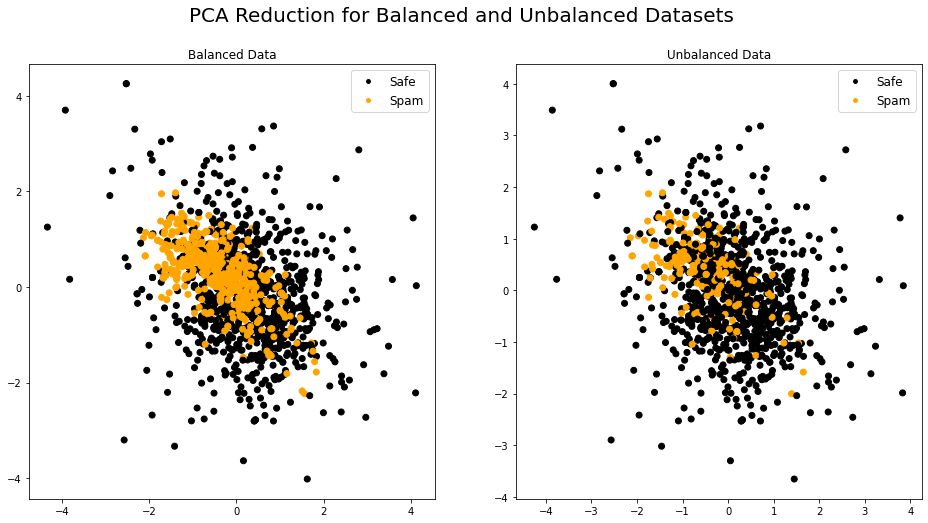

In [23]:
colormap = np.array(['black', 'orange'])
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Safe'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='Spam')]

# plot both PCA results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
fig.suptitle('PCA Reduction for Balanced and Unbalanced Datasets', fontsize=20)
ax1.scatter(data_bal[:,0], data_bal[:,1], color = colormap[y_balanced])
ax1.set_title('Balanced Data')
ax1.legend(handles=legend_elements, loc='upper right', prop={'size': 12})
ax2.scatter(data_unbal[:,0], data_unbal[:,1], color = colormap[y])
ax2.set_title('Unbalanced Data')
ax2.legend(handles=legend_elements, loc='upper right', prop={'size': 12})
plt.show()

### ROC Curve Comparisons

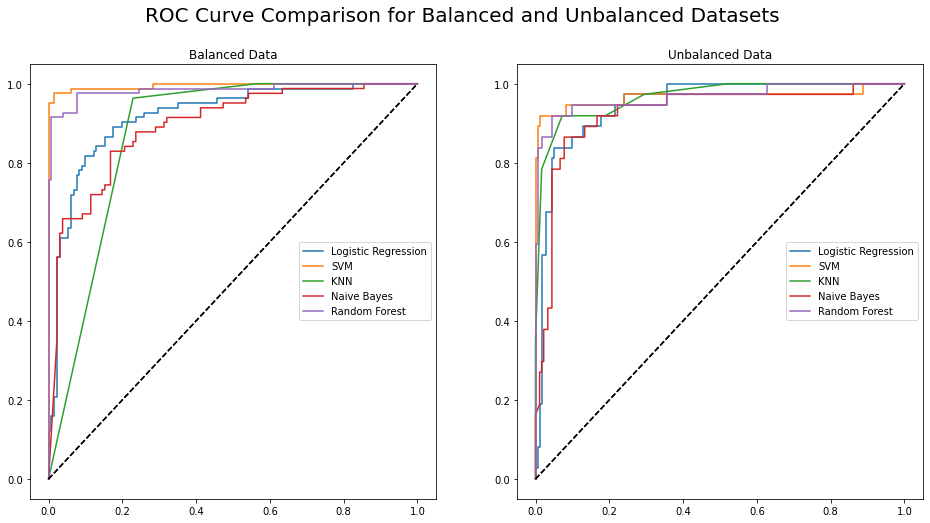

In [24]:
probs_bal = [logit_predprob_bal, svm_predprob_bal, knn_predprob_bal, nb_predprob_bal, rf_predprob_bal]
probs_unbal = [logit_predprob, svm_predprob, knn_predprob, nb_predprob, rf_predprob]

roc_bal = []
roc_unbal = []

i = 0
for probs_list in [probs_bal, probs_unbal]:
    for model in probs_list:
        if i == 0:
            fpr, tpr, thresholds = metrics.roc_curve(y_test_bal, model[:,1])
            roc_bal.append(np.concatenate((np.reshape(fpr, (-1, 1)), np.reshape(tpr, (-1, 1))), axis=1))
        else:
            fpr, tpr, thresholds = metrics.roc_curve(y_test, model[:,1])
            roc_unbal.append(np.concatenate((np.reshape(fpr, (-1, 1)), np.reshape(tpr, (-1, 1))), axis=1))
    i+=1
    
labels = ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes', 'Random Forest']

# plot balanced ROC curves
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
fig.suptitle('ROC Curve Comparison for Balanced and Unbalanced Datasets', fontsize=20)
for i, model in enumerate(roc_bal):
    ax1.plot(model[:,0], model[:,1], label=labels[i])
ax1.plot([[0,0],[1,1]], color='black', linestyle='--')
ax1.set_title('Balanced Data')
ax1.legend(loc='center right')

# plot unbalanced ROC curves
for i, model in enumerate(roc_unbal):
    ax2.plot(model[:,0], model[:,1], label=labels[i])
ax2.plot([[0,0],[1,1]], color='black', linestyle='--')
ax2.set_title('Unbalanced Data')
ax2.legend(loc='center right')
plt.show()

### Precision, Accuracy, F1 Comparisons for Spam Class

- Precision: higher score means lower False Positives. We want to maximize this metric for Spam. 
- Recall: higher score means less False Negatives. We want to maximize this metric for Non-spam.
- F1: harmonic mean of precision and recall for a given class.
- Total Accuracy: an unweighted fraction of correct classifications.

In [30]:
data = [['Logistic Regression', 0.79, 0.84, 0.82, 0.85],
       ['SVM', 0.98, 0.96, 0.97, 0.98],
       ['KNN', 0.72, 0.96, 0.83, 0.85],
       ['Naive Bayes', 0.66, 0.88, 0.75, 0.78],
       ['Random Forest', 0.97, 0.91, 0.94, 0.96]]

balanced_df = pd.DataFrame(data, columns=['Model', 'Spam Precision', 'Spam Recall', 'Spam F1', 'Total Accuracy'])
balanced_df.style.highlight_max(subset=['Spam Precision', 'Spam Recall', 'Spam F1', 'Total Accuracy'],
                                color = 'lightgreen', axis = 0)

,Model,Spam Precision,Spam Recall,Spam F1,Total Accuracy
0,Logistic Regression,0.790000,0.840000,0.820000,0.850000
1,SVM,0.980000,0.960000,0.970000,0.980000
2,KNN,0.720000,0.960000,0.830000,0.850000
3,Naive Bayes,0.660000,0.880000,0.750000,0.780000
4,Random Forest,0.970000,0.910000,0.940000,0.960000


SVM is determined to be the best overall model, offering the highest unweighted accuracy but more importantly offering a superior F1 score of 97%.